In [1]:
num_epochs = 50
class_name = 'Atelectasis'

# Hyperparameters
learning_rate = 0.001
weight_decay = 0

In [2]:
# Install prerequisites

# Install PyCocoTools needed for FasterRCNN
!pip install git+https://github.com/gautamchitnis/cocoapi.git@cocodataset-master#subdirectory=PythonAPI

# Copy useful functions from pytorch vision tools
%cp ../input/pytorch-vision-tools/references/detection/*.* .

  Cloning https://github.com/gautamchitnis/cocoapi.git (to revision cocodataset-master) to /tmp/pip-req-build-hrcsvd4a
  Running command git clone -q https://github.com/gautamchitnis/cocoapi.git /tmp/pip-req-build-hrcsvd4a
  Running command git checkout -b cocodataset-master --track origin/cocodataset-master
  Switched to a new branch 'cocodataset-master'
  Branch 'cocodataset-master' set up to track remote branch 'cocodataset-master' from 'origin'.
  Created wheel for pycocotools: filename=pycocotools-2.0-cp37-cp37m-linux_x86_64.whl size=272660 sha256=9eb1c51cc34c60a85646a798485f4e5b441c1235bc90f4f9ea028540da123aea
  Stored in directory: /tmp/pip-ephem-wheel-cache-mv944opg/wheels/6e/c9/59/56484d4d5ac1ab292a452b4c3870277256551505954fc4a1db
Successfully built pycocotools


In [3]:
# Import required libraries
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader, Subset
from PIL import Image
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from os import path
import torch
import torchvision.utils
import utils
from engine import train_one_epoch, evaluate
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.optim import Adam
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import pickle
import time
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# Define a dataset class which defines how to load images,targets for training and validation
class VinBigDataset(Dataset):
    def __init__(self, img_dir, df, transforms):
        self.img_dir = img_dir
        self.df = df
        self.imgs = df["image_id"].unique()
        self.transforms = transforms
        
    def __len__(self):
        # Return the number of elements in the dataset
        return len(self.imgs)
    
    def __getitem__(self, idx):
        # The dataset iterates over each image id
        # Return the requested image,target from the dataset
        
        # Get the id of the current image
        img_id = self.imgs[idx]
        
        # Get the rows containing annotations for this image
        data_rows = self.df[self.df["image_id"] == img_id]
        boxes = data_rows[["x_min", "y_min", "x_max", "y_max"]].values
        
        # Convert into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        
        # Load the image
        img_path = path.join(self.img_dir, f"{img_id}.png")
        img = Image.open(img_path).convert("RGB")
        
        # Compute the area of the annotated box
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:,0])
        
        # Suppose all instances are not crowd (?)
        num_objs = len(boxes)
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)
        
        # There is only one class, so labels are all ones
        labels = torch.ones((num_objs,), dtype=torch.int64)
        
        # Define the target for this training data point
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = torch.tensor([idx])
        target["area"] = area
        target["iscrowd"] = iscrowd
        
        if self.transforms is not None:
            to_transform = {
                'image': np.array(img),
                'bboxes': target['boxes'],
            }
            transformed = self.transforms(**to_transform)
            img = transformed['image']    
            target['boxes'] = torch.tensor(transformed['bboxes'])
        
        return img, target

In [5]:
# Function to create transforms for preprocessing
def create_transforms(train):
    if train:
        return A.Compose([ 
#             A.Flip(0.5),
            A.Normalize(mean=(0, 0, 0), std=(1, 1, 1), max_pixel_value=255.0, p=1.0), 
            ToTensorV2(p=1.0)
        ])
    else:
        return A.Compose([
            A.Normalize(mean=(0, 0, 0), std=(1, 1, 1), max_pixel_value=255.0, p=1.0), 
            ToTensorV2(p=1.0)
        ])

In [6]:
# Function to create an instance of the model
def create_model():
    # The model has 2 classes
    num_classes = 2
    
    # Use resnet50 pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
        
    # Fetch the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    
    # Replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
   
    return model

In [7]:
# Load the training data csv file
data_dir = "../input/vinbigdata1024mlp/"

df_train = pd.read_csv(f"{data_dir}/train.csv")

# Remove images that do not contain any anomolies
df_train = df_train[df_train["class_name"]==class_name]

# Print out the total number of images and the total number of annotations 
print(f"{df_train['image_id'].nunique()} images")
print(f"{len(df_train.index)} annotations")

186 images
231 annotations


In [8]:
# Create an instance of the dataset and transformations for training
# and validation

train_img_dir = path.join(data_dir, 'train')
# train_img_dir = path.join(data_dir, 'train/train')
train_dataset = VinBigDataset(train_img_dir, df_train, create_transforms(train=True))
val_dataset = VinBigDataset(train_img_dir, df_train, create_transforms(train=False))

# Permute the dataset and split into training and validation set 9:1
torch.manual_seed(5262394)
indices = torch.randperm(len(train_dataset)).tolist()
val_set_size = len(train_dataset) // 10

train_dataset = Subset(train_dataset, indices[:-val_set_size])
val_dataset = Subset(val_dataset, indices[-val_set_size:])

# Create data loaders for the training and validation set. The collate function
# defines how to form a minibatch from the indiviaual data items. In our case we
# just want to collate them into a single list.

data_loader_train = DataLoader(\
    train_dataset, batch_size=5, shuffle=True, num_workers=4, collate_fn=utils.collate_fn)

data_loader_val = DataLoader(\
    val_dataset, batch_size=1, shuffle=False, num_workers=4, collate_fn=utils.collate_fn)

# Print the number of elements in the test and training set
print(f"{len(train_dataset)} items in the training set")
print(f"{len(val_dataset)} items in the validation set")

168 items in the training set
18 items in the validation set


In [9]:
# Cloud Storage
from google.cloud import storage
import os
storage_client = storage.Client(project='s2117072-mlpractical')

def create_bucket(bucket_name):
 bucket = storage_client.create_bucket(bucket_name)

def upload_file(bucket_name, filename):
    bucket = storage_client.get_bucket(bucket_name)
    blob = bucket.blob(filename)
    blob.upload_from_filename(filename)
    
def download_file(bucket_name, filename):
    bucket = storage_client.get_bucket(bucket_name)
    blob = bucket.blob(filename)
    blob.download_to_filename(filename)

def upload_files(bucket_name, source_folder):
 bucket = storage_client.get_bucket(bucket_name)
 for filename in os.listdir(source_folder):
     blob = bucket.blob(filename)
     blob.upload_from_filename(source_folder + filename)

In [10]:
model = create_model()

# use_pre_trained = True
# if use_pre_trained:
#     bucket_name = 's2117072_mlp_20210308_130504'
#     os.makedirs('model_weights', exist_ok=True)
#     blob_name = 'model_weights/model_weights.bin'
#     download_file(bucket_name, blob_name)
#     model.load_state_dict(torch.load(blob_name))

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

In [11]:
# Train the model
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model.to(device)

params = [p for p in model.parameters() if p.requires_grad]

optimizer = Adam(params, lr=learning_rate, weight_decay=weight_decay)
lr_scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=0.00002)

# Create a folder for saving the model weights
%mkdir model_weights
%mkdir stats

train_meters = []
coco_evals = []
t_start = time.time()

for epoch in range(num_epochs):
    # Train over the epoch
    logger = train_one_epoch(model, optimizer, data_loader_train, device, epoch, print_freq=100)
    train_meters.append(logger.meters)
    
    # Evaluate on the validation set
    coco_eval = evaluate(model, data_loader_val, device)
    coco_evals.append(coco_eval.coco_eval)
    
    # Update the learning rate
    lr_scheduler.step()

t_end = time.time()
print(f"Training took {t_end - t_start}")
      
# Save the model weights
torch.save(model.state_dict(), f"model_weights/model_weights.bin")
    
# Save the stats
pickle.dump(train_meters, open(f"stats/train_stats.pkl", 'wb'))
pickle.dump(coco_evals, open(f"stats/val_stats.pkl", 'wb'))
    

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

Epoch: [0]  [ 0/34]  eta: 0:01:28  lr: 0.000031  loss: 0.9854 (0.9854)  loss_classifier: 0.7771 (0.7771)  loss_box_reg: 0.0393 (0.0393)  loss_objectness: 0.1618 (0.1618)  loss_rpn_box_reg: 0.0072 (0.0072)  time: 2.6019  data: 1.0172  max mem: 3745
Epoch: [0]  [33/34]  eta: 0:00:00  lr: 0.001000  loss: 0.2746 (0.3284)  loss_classifier: 0.1186 (0.1683)  loss_box_reg: 0.0872 (0.0800)  loss_objectness: 0.0533 (0.0716)  loss_rpn_box_reg: 0.0067 (0.0085)  time: 0.6068  data: 0.0259  max mem: 4172
Epoch: [0] Total time: 0:00:22 (0.6718 s / it)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


creating index...
index created!
Test:  [ 0/18]  eta: 0:00:06  model_time: 0.1484 (0.1484)  evaluator_time: 0.0014 (0.0014)  time: 0.3613  data: 0.2067  max mem: 4172
Test:  [17/18]  eta: 0:00:00  model_time: 0.0597 (0.0659)  evaluator_time: 0.0006 (0.0007)  time: 0.0873  data: 0.0168  max mem: 4172
Test: Total time: 0:00:01 (0.0906 s / it)
Averaged stats: model_time: 0.0597 (0.0659)  evaluator_time: 0.0006 (0.0007)
Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU

In [12]:
%%bash 
zip -r -q stats.zip stats/*.*

In [13]:
from datetime import datetime
cur_time = datetime.now().strftime('%m%d_%H%M%S')
bucket_name = f's2117072_{cur_time}_{class_name.lower()}'
create_bucket(bucket_name)

In [14]:
upload_file(bucket_name, 'stats.zip')
upload_file(bucket_name, f"model_weights/model_weights.bin")

In [15]:
# Functions for getting and plotting training stats

def get_train_stats(name, stats):
    return [s[name].value for s in stats]

def plot_train_stats(train_stats, name):    
    loss = get_train_stats('loss', train_stats)
    loss_classifier = get_train_stats('loss_classifier', train_stats)
    loss_box_reg = get_train_stats('loss_box_reg', train_stats)
    loss_objectness = get_train_stats('loss_objectness', train_stats)
    loss_rpn_box_reg = get_train_stats('loss_rpn_box_reg', train_stats)
    
    # Plot the training stats
    fig = plt.figure(figsize=(12,8))
    plt.plot(loss, label='loss')
    plt.plot(loss_classifier, label='loss_classifier')
    plt.plot(loss_box_reg, label='loss_box_reg')
    plt.plot(loss_objectness, label='loss_objectness')
    plt.plot(loss_rpn_box_reg, label='loss_rpn_box_reg')
    plt.legend()
    plt.xticks(range(0, len(loss), 5))
    plt.xlabel('Epoch')
    plt.title(f'Training stats {name}')

In [16]:
# Functions for getting and plotting validation stats

def get_val_stats(idx, stats):
    return [s['bbox'].stats[idx] for s in stats]

def plot_val_stats(val_stats, name):
    ap_05_95 = get_val_stats(0, val_stats)
    ap_05 = get_val_stats(1, val_stats)
    ap_75 = get_val_stats(2, val_stats)
    ar_all_md100 = get_val_stats(8, val_stats)

    # Plot the validation stats
    fig = plt.figure(figsize=(12,8))
    plt.plot(ap_05_95, label='AP .05:.95')
    plt.plot(ap_05, label='AP .05')
    plt.plot(ap_75, label='AP .75')
    plt.plot(ar_all_md100, label='AR All Max Dets 100')
    plt.legend()
    plt.xticks(range(0, len(ap_05), 5))
    plt.xlabel('Epoch')
    plt.title(f'Validation stats {name}')

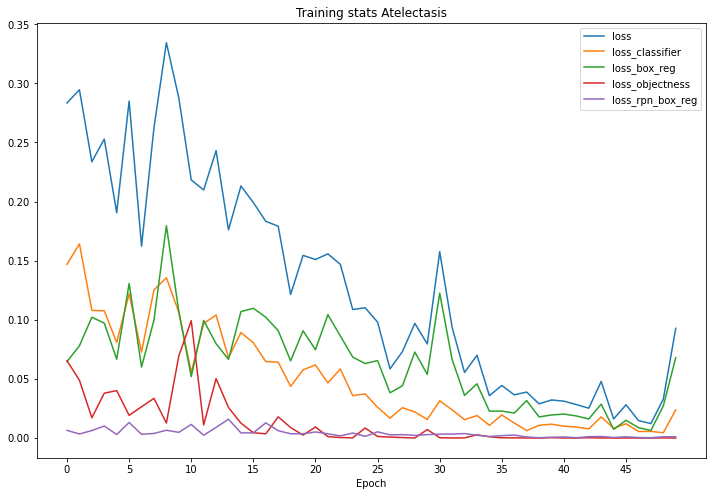

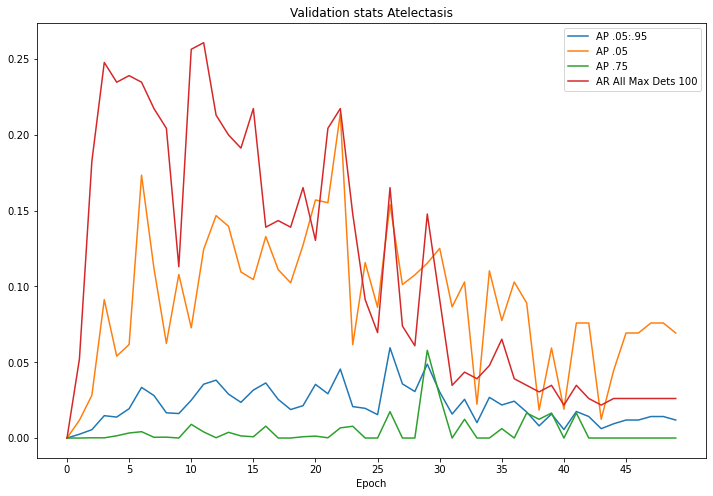

In [17]:
# Plot the stats
plot_train_stats(train_meters, class_name)
plot_val_stats(coco_evals, class_name)    